In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv
/kaggle/input/d/dylphion/images/netflix_PNG15.png
/kaggle/input/images2/netflix-n.jpg


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

# Understanding the dataset

In [4]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


# Data Cleaning

Checking for missing values

In [6]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

The Missing Values are :
* director   : Not much use case at the moment, so dropping the whole column
* cast       : Too many different values, dropping the whole colums for now
* date_added : dropping the ones with no value
* Rating     : dropping it as it amounts to only 4 data left

**Dropping Director and Cast column**

In [7]:
df = df.drop(['director','cast'], axis = 1)

**Dropping null values on the date_added, rating, and duration**

In [8]:
df = df.dropna(subset=['date_added', 'rating', 'duration'])
df['country'] = df['country'].fillna(df['country'].mode()[0])

**Some entries contains more than one values, in this case separating them for easier access**

In [9]:
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

0    United States
1     South Africa
2    United States
3    United States
4            India
Name: principal_country, dtype: object

**Fixing Data Types**

In [10]:
df.dtypes

show_id              object
type                 object
title                object
country              object
date_added           object
release_year          int64
rating               object
duration             object
listed_in            object
description          object
principal_country    object
dtype: object

**Create new entries based on year and month added from date_added column**

In [11]:
df["date_added"] = pd.to_datetime(df['date_added'])
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [12]:
#changing type into category form
df['type'] = pd.Categorical(df['type'])

# Data Visualization

In [13]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,principal_country,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",United States,2021,9
1,s2,TV Show,Blood & Water,South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",South Africa,2021,9
2,s3,TV Show,Ganglands,United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,United States,2021,9
3,s4,TV Show,Jailbirds New Orleans,United States,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",United States,2021,9
4,s5,TV Show,Kota Factory,India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,India,2021,9


## Content Types on Netflix

In [14]:
fig = px.pie(df['type'].value_counts().reset_index(), values='type', names='index', color_discrete_sequence=px.colors.diverging.RdGy)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title="<b>Movies & TV Shows distribution</b>")
fig.show()

* We can see that more than 2/3 of the content released on Netflix are movies at 69.7%.

## Growth of Netflix content over the years

In [15]:
added_year_df = df.loc[df['year_added'] > 2010].groupby(['year_added', 'type']).agg({'show_id': 'count'}).reset_index()


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=added_year_df.loc[added_year_df['type'] == 'Movie']['year_added'],
    y=added_year_df.loc[added_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Year Added',
    marker_color= 'firebrick',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'TV Show']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Year Added',
    marker_color= 'DarkSlateGray',
))

fig.update_xaxes(categoryorder='total descending')
fig.update_layout(title="<b>Movies & TV Shows added over time</b>",template="plotly_white")
fig.show()

* It seems like movies are being added more over time in compared to tv shows. Starting at 2016, the numbers of movie being added had been increasing very rapidly and peaks at 2019

## Content distributed by countries

In [16]:
country_df = df['principal_country'].value_counts().reset_index().head(10)
dfh = df['principal_country'].value_counts().reset_index().head(3)

colors = ['#221f1f',]*10
colors[0] = colors[1] = colors[2] = 'Firebrick'
    

fig = px.bar(country_df, x='index', y='principal_country',
                   title='<b>Top 10 Countries of Netflix Content<b><br><sup>The top three have been highlighted</sup>',
                   labels={'index':'Countries', 'principal_country':'Number of Contents'},
                   template= "plotly_white",
                   )

fig.update_traces(marker_color=colors)
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [17]:
country_df2 = df['principal_country'].value_counts().reset_index()
country_df2 = country_df2[country_df2['principal_country'] /  country_df2['principal_country'].sum() > 0.005]

fig = px.pie(country_df2, values='principal_country', names='index', color_discrete_sequence=px.colors.diverging.RdGy,
             title='<b>Netflix content based of countries</b>',
             labels={'index':'Country', 'principal_country':'Count'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

* It's clear that United States has the most content on Netflix at almost 50% overall
* Suprisingly India comes as second on the number of content, beating United Kingdom
* We can also see that there is also a lot of content coming from Asian country

## Genre Analysis
**Defining the Genres**

In [18]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))

**Divides the genres into two types of content**

In [19]:
movie_df = df[df['type'] == 'Movie']
show_df = df[df['type'] == 'TV Show']

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.colors

def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

In [21]:
def top_genres(df, title):
    colors = ['#221f1f',]*20
    colors[0] = colors[1] = colors[2] = colors[3] = colors[4] = 'Firebrick'
    
    genres_df = calculate_mlb(df['genre'])
    tdata = genres_df.sum().sort_values(ascending=False)
    
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
        marker=dict(color="Firebrick")
    ))
    fig.update_traces(marker_color=colors)
    fig.update_xaxes(categoryorder='total descending')
    fig.update_traces(texttemplate='%{y}', textposition='outside')
    fig.update_layout(title="<b>Top {} Genres</b><br><sup>The top five have been highlighted</sup>".format(title), template="plotly_white")
    fig.show()

In [22]:
def genre_heatmap(df, title):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', 'Firebrick','LavenderBlush'])
    
    genres_df = calculate_mlb(df['genre'])
    movie_corr = genres_df.corr()
    movie_mask = np.zeros_like(movie_corr, dtype=np.bool)
    movie_mask[np.triu_indices_from(movie_mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    pl = sns.heatmap(movie_corr, mask=movie_mask, cmap= cmap, vmax=.3, vmin=-.3, center=0, linewidths=.25,
                 cbar_kws={"shrink": 0.6})
    ax.set_title("Genre Correlation in {}".format(title), fontweight='bold',fontsize=15)
    plt.show()

**Let's Start the analysis on the Movies genre**

In [23]:
top_genres(movie_df, 'Movies')

There are 20 types in the Netflix Movies Dataset


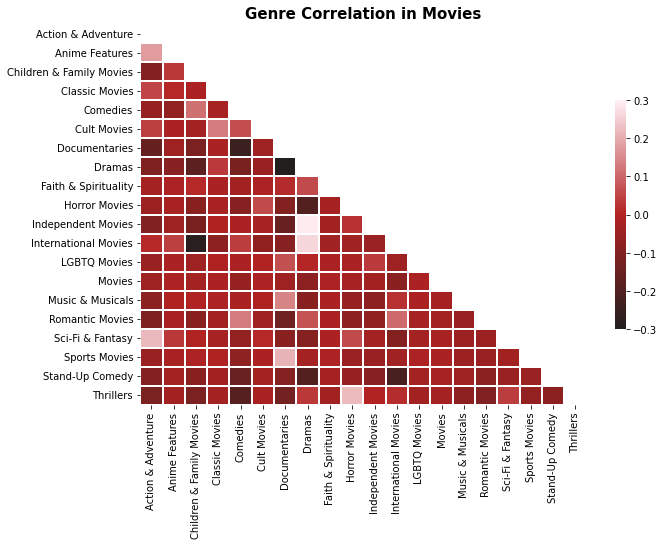

In [24]:
genre_heatmap(movie_df, 'Movies')

From both analyses, we can see that :
* The top 5 genres for movies are International Movies, Dramas, Comedies, Documentaries and Action & Adventure.
* It seems that most International Movies and Indeoendent Movies tend to be Dramas.
* Interestingly, International Movies are rarely the in the Childen's genre.

**Now on to the TV Shows**

In [25]:
top_genres(show_df, 'TV Shows')

There are 22 types in the Netflix TV Shows Dataset


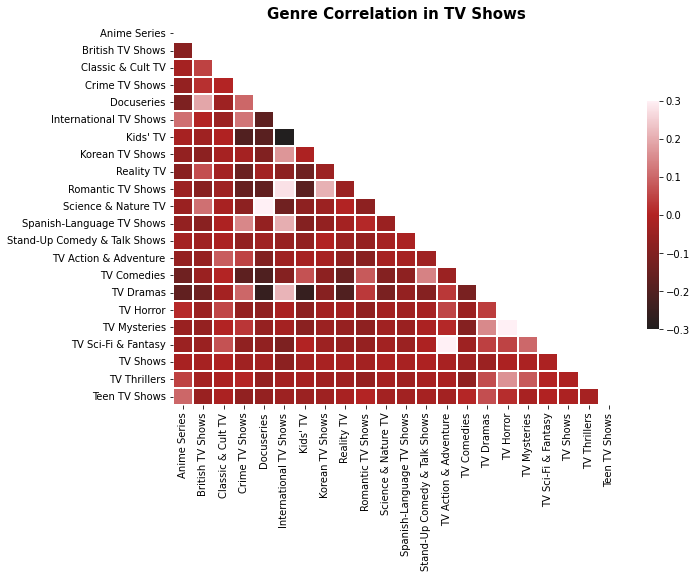

In [26]:
genre_heatmap(show_df, 'TV Shows')

From both analyses, we can see that :
* The top 5 genres for TV Shows are International TV Shows, TV Dramas, TV Comedies, Crime TV Shows and Kids' TV.
* It seems that most of the Sci-fi & Fantasy shows are about Action & Adventure.
* Different from Movies, most International TV Shows are Romance genre.
* In TV Shows, Mysteries and Horrors are the most common along with Docuseries with Science & Nature Genre.
* Seems like the Kids' genre doesn't goes well with Dramas and International TV Shows.

## Duration analysis
### Movies Length Analysis

In [27]:
movie_duration = movie_df['duration'].apply(lambda x: int(x.split(' ')[0])).astype(int).reset_index()
movie_duration["Count"] = movie_duration['duration']**0

fig = px.histogram(movie_duration, x="duration", y="Count",
                    title='<b>Movies Duration Distribution<b>',
                    labels={'duration':'<b>Minutes<b>'},
                    template= "plotly_white",
                    color_discrete_sequence=['firebrick']
)
fig.update_layout(yaxis_title=None)
fig.show()

#Finding the mean, min, and max duration
movie_mean = movie_duration['duration'].mean()
movie_low = movie_duration['duration'].min()
movie_high = movie_duration['duration'].max()

print("The average duration of movies releases in Netflix is {} minutes".format(round(movie_mean)))
print("The shortest movie released in Netflix is {} minutes".format(movie_low))
print("The longest movie released in Netflix is {} minutes".format(movie_high))

The average duration of movies releases in Netflix is 100 minutes
The shortest movie released in Netflix is 3 minutes
The longest movie released in Netflix is 312 minutes


### TV Shows Series Analysis

In [28]:
#show_df1 tallies TV Shows based on duration
show_df1 = show_df.groupby('duration').size().reset_index(name='Count')

fig = px.bar(show_df1, x='duration', y= 'Count',
                   title='<b>TV Shows Series Distribution<b>',
                   labels={'duration':'Duration of the Show'},
                   template= "plotly_white",
                   )

fig.update_traces(marker_color='firebrick')
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

longest_show = show_df[show_df['duration'].str.contains('17 Seasons')]['title'].iloc[-1]
print('The longest TV Shows on Netflix is {} at 17 seasons'.format(longest_show, index=False))

The longest TV Shows on Netflix is Grey's Anatomy at 17 seasons


# Netflix Title Overview with Word Cloud

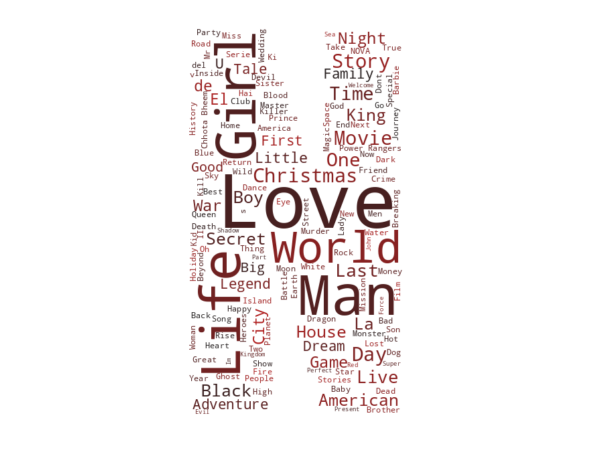

In [29]:
from wordcloud import WordCloud
from PIL import Image
import random

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', 'Firebrick'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('../input/images2/netflix-n.jpg'))

wordcloud = WordCloud(background_color = 'white', width = 1000,  height = 1000, max_words = 150, colormap=cmap, mask = mask).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Thanks for reading